In [11]:
from geomet import wkt
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from SPARQLWrapper import SPARQLWrapper, JSON

In [12]:
# Set the SPARQL endpoint and request that the response is in JSON
sparql = SPARQLWrapper("https://stko-kwg.geog.ucsb.edu/sparql")
sparql.setReturnFormat(JSON)

In [13]:
# From the schema, we can see that kwgr:StormTrack contains the individual track points in
# a list of StormTracklet objects, related to through kwg-ont:hasStormTracklet. Each StormTracklet is
# linked to a geosparql:Geometry, which in turn has the point information.
query = """PREFIX kwgr: <http://stko-kwg.geog.ucsb.edu/lod/resource/>
PREFIX kwg-ont: <http://stko-kwg.geog.ucsb.edu/lod/ontology/>
PREFIX geosparql: <http://www.opengis.net/ont/geosparql#>
SELECT * WHERE { 
    <http://stko-kwg.geog.ucsb.edu/lod/resource/StormTrack.2005236N23285> kwg-ont:hasStormTracklet ?tracklet .
    ?tracklet geosparql:hasDefaultGeometry ?default_geometry .
    ?default_geometry geosparql:asWKT ?geometry .
}"""
sparql.setQuery(query)

In [14]:
# Create an empty dataframe to hold the Latitude and Longitude values of each point in the storm track
storm_record = pd.DataFrame(columns=['Lat', 'Long'])

try:
    query_result = sparql.queryAndConvert()
    # Loop over the results and add the Lat & Long for each tracklet to the storm record
    for track_result in query_result["results"]["bindings"]:
        coordinates = wkt.loads(track_result['geometry']['value'])['coordinates']
        storm_record.loc[len(storm_record.index)] = [coordinates[0], coordinates[1]]
except Exception as e:
    print(f"There was a problem processing the data: {e}")

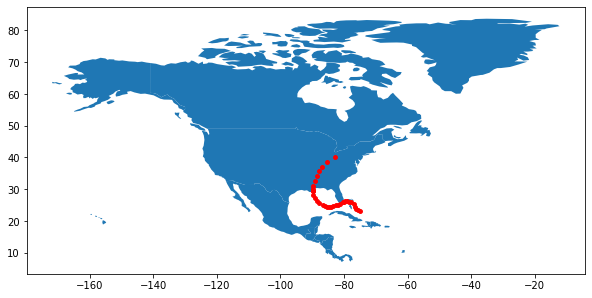

In [15]:
# Turn the dataframe into a list of shapely Points
geometry = [Point(xy) for xy in zip(storm_record['Lat'], storm_record['Long'])]
gdf = GeoDataFrame(storm_record, geometry=geometry)

# Use the default geopandas low resolution map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['continent'] == "North America"]
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
plt.show()

gdf.to_file("katrina_storm_track.shp")